# Long-run performance

In [1]:
import torch
import numpy as np
import scipy.stats
import lp_wealth
from sim_helpers import *
from notebook_helpers import *

In [7]:
num_samples = 1000

sigma = torch.tensor(1.6)
mu = torch.tensor(1.)
gamma = torch.ones(num_samples) * .9

time_step = torch.min(get_max_time_step(gamma, sigma, mu))
num_steps = max(get_min_time_steps(sigma, gamma, time_step), 300000)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

checkpoints = sim_loop(sim, num_steps, num_checkpoints = num_steps/100)

time = np.array([torch.mean(checkpoint.time) for checkpoint in checkpoints])
amm_wealth = np.array([torch.mean(checkpoint.wealth) for checkpoint in checkpoints])
hodl_wealth = np.array([torch.mean(checkpoint.market_price) for checkpoint in checkpoints])



1 0.0011339187622070312
30001 17.08463191986084
60001 18.053740739822388
90001 17.85871720314026
120001 16.765023231506348
150001 16.852745294570923
180001 18.157360792160034
210001 18.732053518295288
240001 18.307944774627686
270001 18.182451725006104


Text(0.5, 1.0, 'Mean wealth for HODL vs. Uniswap LP ($\\mu$ = 1.0, $\\sigma$ = 1.6)')

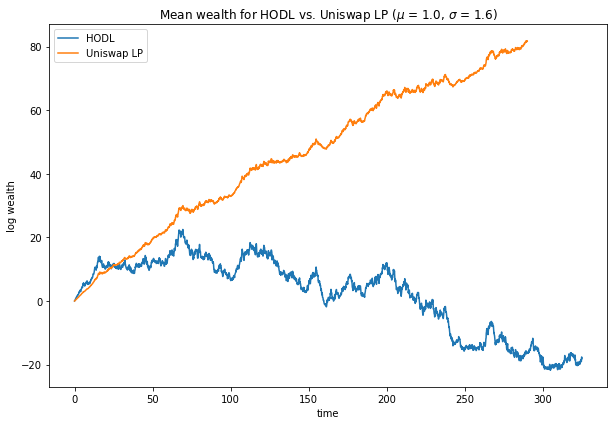

In [8]:
from matplotlib.pyplot import figure
width=10
figure(figsize=(width,width/1.5))
sbn.lineplot(time, np.log(hodl_wealth), label="HODL")
sbn.lineplot(time, np.log(amm_wealth), label="Uniswap LP")
plt.xlabel("time")
plt.ylabel("log wealth")
plt.title(f"Mean wealth for HODL vs. Uniswap LP ($\mu$ = {float(mu)}, $\sigma$ = {round(float(sigma),2)})")


# Volatility Drag

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':


Text(0.5, 1.0, 'realized wealth vs. expected value in the presence of volatility')

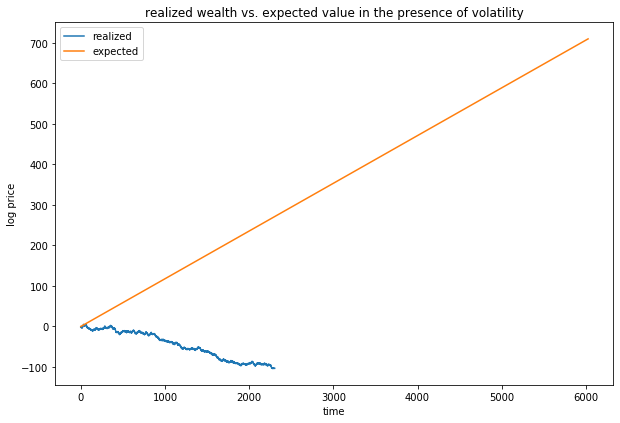

In [4]:
num_steps = 10000
flips = torch.bernoulli(torch.ones(num_steps)*.5)
returns = torch.where(flips==0, torch.tensor(.5), torch.tensor(1.75))
value = torch.cumprod(returns,0)

width=10
figure(figsize=(width,width/1.5))
sbn.lineplot(range(num_steps), np.log(value),label="realized")
sbn.lineplot(range(num_steps), np.log(1.125**np.arange(num_steps)),label="expected")
plt.xlabel("time")
plt.ylabel("log price")
plt.title(f"realized wealth vs. expected value in the presence of volatility")



# Fee discontinuity

Text(0.5, 1.0, 'wealth growth rate vs. fee ($\\mu$ = 1.0, $\\sigma$ = 1.6)')

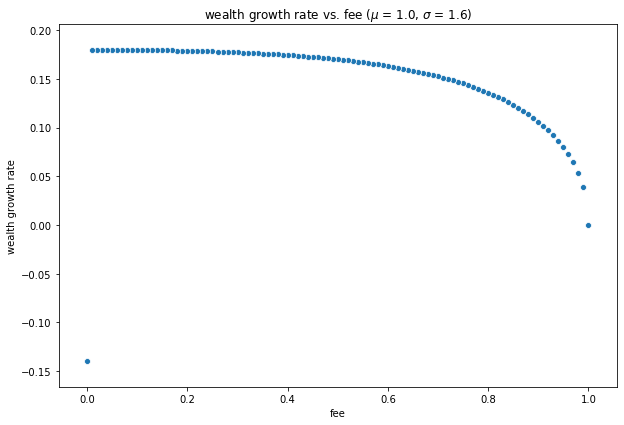

In [5]:
num_samples = 1000

sigma = torch.tensor(1.6)
mu = torch.tensor(1.)
gamma = torch.arange(0., 101, 1)/100

time_step = torch.tensor(1.)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)
growth = sim.predict_wealth_growth_rate()

width=10
figure(figsize=(width,width/1.5))
sbn.scatterplot(1-gamma, growth)
plt.xlabel("fee")
plt.ylabel("wealth growth rate")
plt.title(f"wealth growth rate vs. fee ($\mu$ = {float(mu)}, $\sigma$ = {round(float(sigma),2)})")

# Prediction Validation

30692
1 0.0006787776947021484
3070 1.7290163040161133
6139 1.7717077732086182
9208 1.794717788696289
12277 1.814847469329834
15346 1.8197009563446045
18415 1.86350417137146
21484 1.8238415718078613
24553 1.8177847862243652
27622 1.8708195686340332
30691 1.88720703125


[Text(0, 0.5, 'G'),
 Text(0.5, 0, 'pred'),
 Text(0.5, 1.0, 'predicted wealth growth vs. actual')]

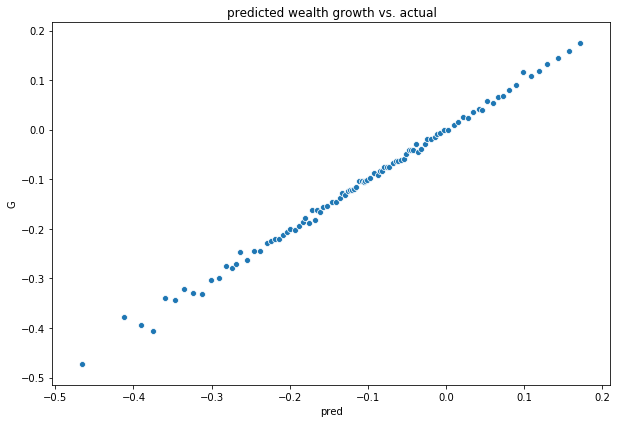

In [6]:
num_samples = 1000

mu = (torch.rand(num_samples) - .5)
sigma = torch.rand(num_samples) + .5
gamma = torch.rand(num_samples) * .8 + .1

time_step = get_max_time_step(gamma, sigma, mu)
num_steps = get_min_time_steps(sigma, gamma, time_step)
print(num_steps)
sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

sim_loop(sim, num_steps)

d = mu - sigma**2 / 2
predicted_growth = d/2 * ((1 + gamma**(4 * d/sigma**2))/(1 - gamma**(4 * d/sigma**2))*(1-gamma)/(1+gamma)+1)
predicted_growth_negative_d = -d/2 * ((1 + gamma**(-4 * d/sigma**2))/(1 - gamma**(-4 * d/sigma**2))*(1-gamma)/(1+gamma)-1)

width=10
figure(figsize=(width,width/1.5))

ax=bin_plot(predicted_growth_negative_d, sim.compute_wealth_growth_rate())

ax.set(xlabel='pred', ylabel='G',title="predicted wealth growth vs. actual")
